In [11]:
# Task 1 Financial News Collection 
import requests 
import numpy as np 
import pandas as pd
from bs4 import BeautifulSoup
GOOGLE_KEYWORDS = ['Google', 'GOOG', 'Alphabet', 'Alphabet Inc', 'GOOGL', 'sundar pichai']
def fetch_financial_news(source,url,articles):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve data form {url}")
        return []
    soup = BeautifulSoup(response.text, "xml")
    items=soup.find_all("item")
    for item in items :
        headline=item.find("title")
        pub_Date=item.find("pubDate")

        articles.append({
            "source":source,
            "headline":headline.text if headline else "N/A",
            "pub_Date":pub_Date.text if pub_Date else "N/A"
        })

rss_feeds = {
    'Wall Street Journal':'https://feeds.content.dowjones.io/public/rss/RSSUSnews',
    'Bloomberg':'https://feeds.bloomberg.com/markets/news.rss',
    'MarketWatch':'https://feeds.content.dowjones.io/public/rss/mw_marketpulse',
    'CNBC':'https://search.cnbc.com/rs/search/combinedcms/view.xml?partnerId=wrss01&id=19854910',
    'RSS Google News' : 'https://rss.app/feeds/EoLrBWZwpW2DkCrL.xml'
}

articles =[]
fetch_financial_news('Wall Street Journal','https://feeds.content.dowjones.io/public/rss/RSSUSnews',articles)
fetch_financial_news('Bloomberg','https://feeds.bloomberg.com/markets/news.rss',articles)
fetch_financial_news('MarketWatch','https://feeds.content.dowjones.io/public/rss/mw_marketpulse',articles)
fetch_financial_news('CNBC','https://search.cnbc.com/rs/search/combinedcms/view.xml?partnerId=wrss01&id=19854910',articles)
fetch_financial_news('RSS Google News','https://rss.app/feeds/EoLrBWZwpW2DkCrL.xml',articles)

df=pd.DataFrame(articles)
df.to_csv("news_raw.csv",index=False)


In [12]:
# Task 3 : News Data Cleaning and Standardization
import pandas as pd 
import numpy as np
news_df=pd.read_csv('news_raw.csv') #read the csv file 
pd.set_option("display.max_colwidth", None) #show full column content
pd.set_option("display.max_columns", None)
news_df['pub_Date']=pd.to_datetime(news_df['pub_Date'],utc=True) #convert to a datetime object 
news_df["date"]=news_df["pub_Date"].dt.date #extract date from a datetime object
news_df["headline_length"]=news_df["headline"].str.len() #calculate headline length
news_df.to_csv("news_cleaned.csv",index=False) #save the cleaned data to a new csv file

In [13]:
# Task 4 : Stock Price Data Collection
import pandas as pd 
import numpy as np
import yfinance as yf 
ticker="GOOG"
stock_df=yf.download(ticker,period="730d",interval="1d")
stock_df.to_csv("stock_data.csv",index=True)

[*********************100%***********************]  1 of 1 completed


In [14]:
# Task 6 : Intelligent Data Merging
import pandas as pd 
import numpy as np
news_df=pd.read_csv("news_cleaned.csv")
stock_df=pd.read_csv("stock_data.csv",skiprows=2)
stock_df["Date"] = pd.to_datetime(stock_df["Date"],dayfirst=True,format="%Y-%m-%d")
news_df["date"] = pd.to_datetime(news_df["date"],dayfirst=True)
merged_df=pd.merge(
    news_df,
    stock_df,
    left_on="date",
    right_on="Date",
   how="left"
)
merged_df["is_trading_day"] = merged_df["Date"].notna()
merged_df=merged_df.rename(columns={"Unnamed: 1":"Close"})
merged_df=merged_df.rename(columns={"Unnamed: 2":"High"})
merged_df=merged_df.rename(columns={"Unnamed: 3":"Low"})
merged_df=merged_df.rename(columns={"Unnamed: 4":"Open"})
merged_df=merged_df.rename(columns={"Unnamed: 5":"Volume"})

merged_df.to_csv("merged_final_data.csv", index=False)
     

C:\Users\Amol Natu\AppData\Local\Temp\ipykernel_32468\3898152869.py:7: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  news_df["date"] = pd.to_datetime(news_df["date"],dayfirst=True)


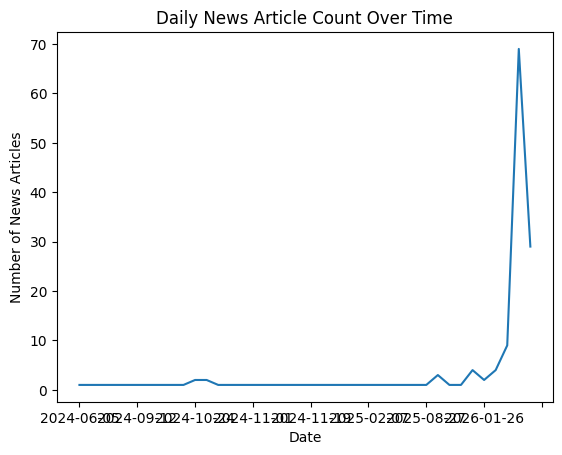

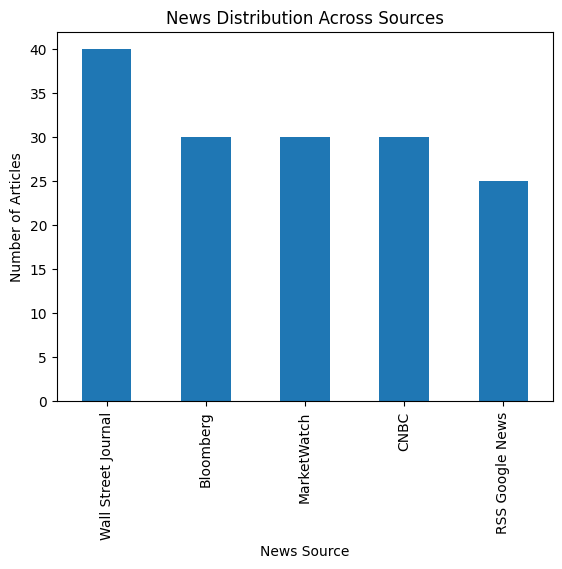

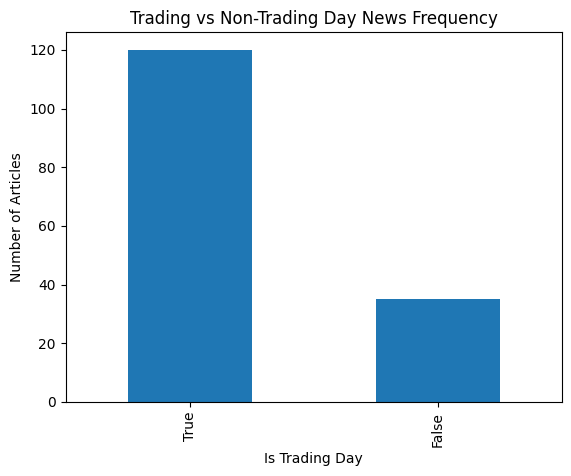

In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
merged_df=pd.read_csv('merged_final_data.csv')
news_per_day=merged_df.groupby('date').size()
plt.figure()
news_per_day.plot(kind="line")
plt.xlabel("Date")
plt.ylabel("Number of News Articles")
plt.title("Daily News Article Count Over Time")
plt.show()
news_by_source = merged_df["source"].value_counts()

plt.figure()
news_by_source.plot(kind="bar")
plt.xlabel("News Source")
plt.ylabel("Number of Articles")
plt.title("News Distribution Across Sources")
plt.show()
trading_vs_non = merged_df["is_trading_day"].value_counts()

plt.figure()
trading_vs_non.plot(kind="bar")
plt.xlabel("Is Trading Day")
plt.ylabel("Number of Articles")
plt.title("Trading vs Non-Trading Day News Frequency")
plt.show() 
     

In [16]:
#Task 8 Sentiment Analysis 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch
from transformers import pipeline


pipe = pipeline(
    "text-classification",
    model="ProsusAI/finbert",
    return_all_scores=True
)

merged_df = pd.read_csv("merged_final_data.csv")

texts = merged_df["headline"].astype(str).tolist()
results = pipe(texts, batch_size=16)

def finbert_score(scores):
    if isinstance(scores, dict):
        label = scores["label"].lower()
        score = scores["score"]
        return score if label in ["positive", "neutral"] else -score

    scores_dict = {d["label"].lower(): d["score"] for d in scores}
    return scores_dict.get("positive", 0) - scores_dict.get("negative", 0)

merged_df["finbert_sentiment"] = [finbert_score(r) for r in results]

merged_df.to_csv("merged_with_sentiment.csv", index=False)

Loading weights: 100%|██████████| 201/201 [00:01<00:00, 106.89it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


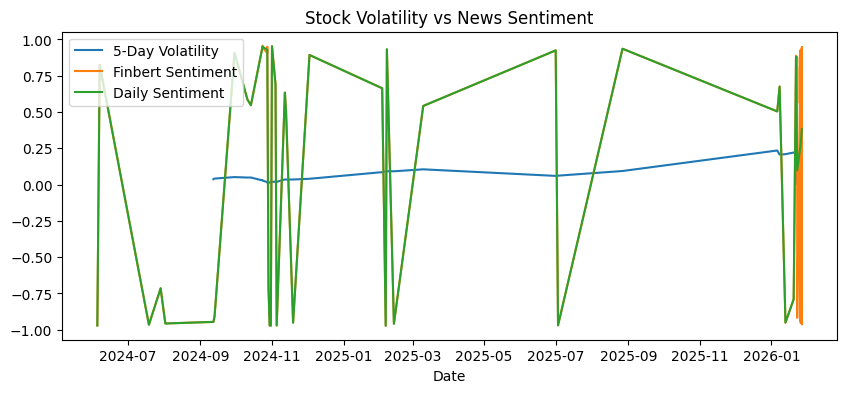

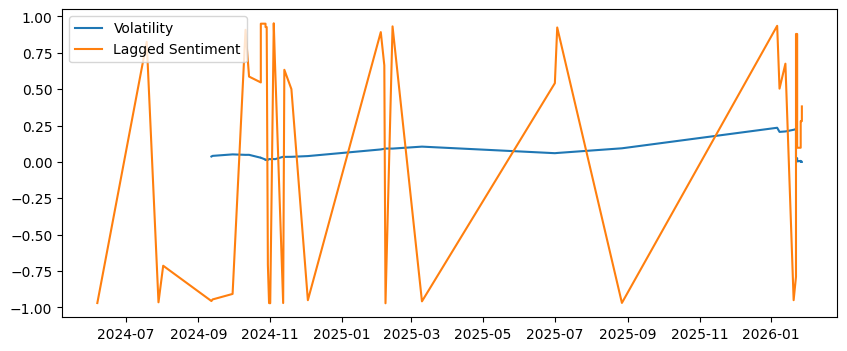

                     volatility_5d  finbert_sentiment_x
volatility_5d             1.000000            -0.065845
finbert_sentiment_x      -0.065845             1.000000
                     volatility_5d  finbert_sentiment_y
volatility_5d             1.000000            -0.118848
finbert_sentiment_y      -0.118848             1.000000


In [2]:
# Task 9 Analyzing Sentiment vs Stock Volatility 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data with sentiment
df = pd.read_csv("merged_with_sentiment.csv")

# Convert date
df["date"] = pd.to_datetime(df["date"])

# DAILY SENTIMENT (from ALL news)

daily_sentiment = (
    df.groupby("date")["finbert_sentiment"]
      .mean()
      .reset_index()
)


# STOCK DATA (trading days only)

stock_df = df[df["is_trading_day"] == True].copy()
stock_df = stock_df.sort_values("date")

# Daily returns
stock_df["return"] = stock_df["Close"].pct_change()

# Rolling volatility
stock_df["volatility_5d"] = stock_df["return"].rolling(5).std()
stock_df["volatility_10d"] = stock_df["return"].rolling(10).std()

# MERGE SENTIMENT WITH STOCK DATA
final_df = pd.merge(
    stock_df,
    daily_sentiment,
    on="date",
    how="left"
)

# PLOT

plt.figure(figsize=(10,4))
plt.plot(final_df["date"], final_df["volatility_5d"], label="5-Day Volatility")
plt.plot(final_df["date"], final_df["finbert_sentiment_x"], label="Finbert Sentiment")
plt.plot(final_df["date"], final_df["finbert_sentiment_y"], label="Daily Sentiment")
plt.legend()
plt.title("Stock Volatility vs News Sentiment")
plt.xlabel("Date")
plt.show()

final_df["sentiment_lag1"] = final_df["finbert_sentiment_y"].shift(1)

plt.figure(figsize=(10,4))
plt.plot(final_df["date"], final_df["volatility_5d"], label="Volatility")
plt.plot(final_df["date"], final_df["sentiment_lag1"], label="Lagged Sentiment")
plt.legend()
plt.show()

final_df.to_csv("trading_days_with_sentiment.csv", index=False)
corr = final_df[["volatility_5d", "finbert_sentiment_x"]].corr()
corr2 = final_df[["volatility_5d", "finbert_sentiment_y"]].corr()
print(corr)
print(corr2)

c:\Users\Amol Natu\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Amol Natu\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Amol Natu\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi


MODEL PERFORMANCE:

---- Logistic Regression ----
Accuracy: 0.974
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Confusion Matrix:
[[37  0]
 [ 1  0]]

---- Random Forest ----
Accuracy: 0.974
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Confusion Matrix:
[[37  0]
 [ 1  0]]

---- XGBoost ----
Accuracy: 0.974
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Confusion Matrix:
[[37  0]
 [ 1  0]]



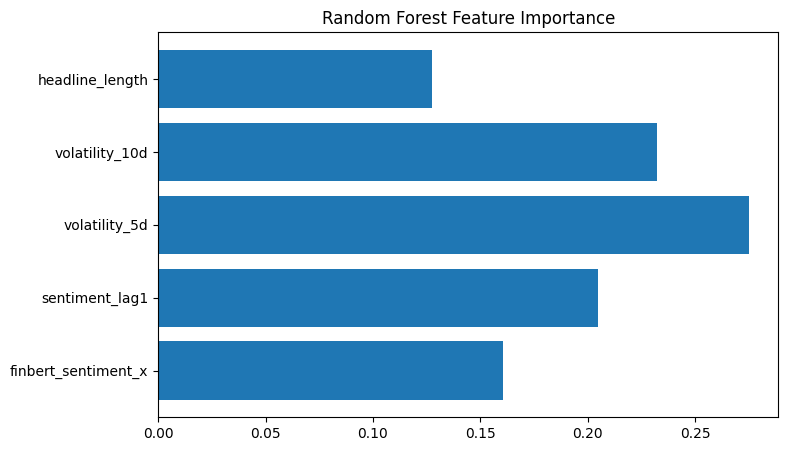

In [ ]:
# Task 10 Predictive Modeling
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("trading_days_with_sentiment.csv")

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date")


df = df.dropna(subset=['finbert_sentiment_x', 'return'])


df['target'] = (df['return'] > 0).astype(int)

features = [
    'finbert_sentiment_x',
    'sentiment_lag1',
    'volatility_5d',
    'volatility_10d',
    'headline_length'
]

df = df.dropna(subset=features)

X = df[features]
y = df['target']

split_date = df['Date'].iloc[int(len(df) * 0.8)]  # 80% train, 20% test

X_train = X[df['Date'] < split_date]
X_test  = X[df['Date'] >= split_date]
y_train = y[df['Date'] < split_date]
y_test  = y[df['Date'] >= split_date]

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=4)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1 Score": f1_score(y_test, preds),
        "Confusion Matrix": confusion_matrix(y_test, preds)
    }

print("\nMODEL PERFORMANCE:\n")
for name, metrics in results.items():
    print(f"---- {name} ----")
    print(f"Accuracy: {metrics['Accuracy']:.3f}")
    print(f"Precision: {metrics['Precision']:.3f}")
    print(f"Recall: {metrics['Recall']:.3f}")
    print(f"F1 Score: {metrics['F1 Score']:.3f}")
    print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}\n")

rf = models["Random Forest"]
importances = rf.feature_importances_

plt.figure(figsize=(8,5))
plt.barh(features, importances)
plt.title("Random Forest Feature Importance")
plt.show()

pd.DataFrame(results).to_csv("model_results.csv")